# Generalized Boltzmann equations

$\newcommand{\R}{\mathbb R}$
A generic form of the **Boltzmann collision operator** may be written as
$$ Q[f](v) = \iiint (f(v'_\ast) f(v') - f(v_\ast) f(v)) K(v'_\ast,v',v_\ast,v) \, dv'_\ast dv' dv_\ast $$

Intuitively, the kernel $K$ measures how frequently a pair of particles with velocities $v'_\ast$ and $v'$ collide and become of velocities $v_\ast$ and $v$.

The kernel $K$ can be any nonnegative function satisfying at least the following two symmetries:
* pre-post collisional symmetry: $K(v'_\ast, v', v_\ast,v) = K(v_\ast, v, v'_\ast,v')$.
* Star-symmetry: $K(v'_\ast, v', v_\ast,v) = K(v', v'_\ast, v,v_\ast)$

These two conditions allow us to perform the two usual changes of variables for symmetrization. The first one corresponds to the reversibility of trajectories. The second one corresponds to the idea that $v$ and $v_\ast$ are indistinguishable. Any generalic collision operator $Q$ as above provides conservation of mass and monotonicity of entropy.
\begin{align*}
\int Q[f] \, dv &= 0, \\
\int Q[f] \log f \, dv &= -\frac 14 \iint (f'_\ast f' - f_\ast f) \log\left( \frac {f'_\ast f'}{f_\ast f} \right) \, K(v'_\ast, v', v_\ast,v) \, d v'_\ast d v' dv_\ast dv
\end{align*}

In the usual Boltzmann collision operator, we further restrict the kernel $K$ to enforce conservation of momentum and energy. In order to achieve that, the kernel $K$ must be a singular measure supported inside certain surfaces in $\R^{4d}$. The precise conditions are the following
* *Conservation of momentum* holds if $K$ is supported on $v'_\ast + v' = v_\ast + v$.
* *Conservation of energy* holds if $K$ is supported on $|v'_\ast|^2 + |v'|^2 = |v_\ast|^2 + |v|^2$.

Once we impose conservation of momentum, every exponential $f(v) = a e^{b \cdot v}$ is stationary (albeit with infinite mass). If we impose conservation of momentum and energy, then we get the usual Maxwellians $f(v) = a e^{-c |v|^2 + b \cdot v}$.

The **Landau collision operator** is a differential operator that can be obtained as the limit of a sequence of Boltzmann collision operators whose kernels $K$ concentrate around $v'=v$ and $v'_\ast = v_\ast$. For the **Krieger-Strain** model, the family of kernels would not conserve momentum and energy and the equation is not expected to blow-up either.

It is conceivable that every equation $\partial_t f = Q[f]$ may satisfy some remarkable estimates that are yet to be discovered. In order to simplify the analysis as much as possible, we here consider the discrete version
$$ Q[f]_\ell = \sum_{ijk} (f_i f_j - f_k f_\ell) k_{i,j,k,\ell}.$$
The following function, computes this *discrete Boltzmann operator*.

In [2]:
function Q(f::Vector{<:Real},kernel::Array{<:Real,4})
    N = length(f)
    g = zeros(typeof(f[1]),N)
    for (i,j,k,l) in Tuple.(CartesianIndices(kernel))
            g[l] += kernel[i,j,k,l] * (f[i]*f[j] - f[k]*f[l])
    end
    return g
end

# The following is a more efficient implementation assumming conservation of momentum

function Qm(f::Vector{<:Real},kernel::Array{<:Real,4})
    N = length(f)
    g = zeros(typeof(f[1]),N)
    for (i,j,l) in Tuple.(CartesianIndices(((1:N,1:N,1:N))))
        k = i+j-l
        if ((k>0)&&(k<=N))
            g[l] += kernel[i,j,k,l] * (f[i]*f[j] - f[k]*f[l])
        end
    end
    return g
end
                

Qm (generic function with 1 method)

In order to write experimental code, we may start with kernels that are randomly initialized. The following function returns a symmetrized version of any given kernel, so that it satisfies the two basic symmetry requirements in the definition of $Q$.

In [3]:
function symmetrize(kernel::Array{<:Real,4})
    N = size(kernel)[1]
    k0 = similar(kernel)
    for i in CartesianIndices(kernel)
        k0[i] = max(0.,(kernel[i] + kernel[i[2],i[1],i[4],i[3]] + kernel[i[3],i[4],i[1],i[2]] + kernel[i[4],i[3],i[2],i[1]])/4)
    end
    return k0
end

symmetrize (generic function with 1 method)

The following function forces a kernel to be supported on $k_i+k_j = k_k + k_\ell$, and therefore make the collision operator $Q$ satisfy conservation of momentum. This mean that after we apply this function, we will have
$$ \sum_\ell \ell Q[f]_\ell = 0. $$
It is the discrete version of
$$ \int v Q[f](v) \, dv = 0. $$

While it would be interesting to play with kernels that conserve energy as well, it seems awkward to impose $i^2+j^2 = k^2 + \ell^2$ at the discrete level, since Pythagorean pairs are not that abundant.

Recall that having conservation of momentum already makes every exponential function stationary.

In [4]:
function conserve_momentum!(kernel::Array{<:Real,4})
    for i in CartesianIndices(kernel)
        if (i[1]+i[2] != i[3]+i[4]) kernel[i]=0 end
    end
end
    

conserve_momentum! (generic function with 1 method)

We now define the functions that measure the important macroscopic quantities associated with $f$ and also any other we might want to explore. They are the counterparts of the following quantities in their continuous setting.

1. Mass.
$$ m := \int f(v) \, dv $$
2. Momentum.
$$ q := \int f(v) v \, dv $$
3. Energy
$$ e := \int f(v) |v|^2 \, dv $$
4. Entropy
$$ h := \int f(v) \log f(v) \, dv $$
5. Entropy dissipation
$$ D := -\partial_t h = \frac 14 \iiiint (f'_\ast f' - f_\ast f) \log \left( \frac {f'_\ast f'}{f_\ast f} \right)  k(\cdot\cdot\cdot\cdot) \, d \cdot\cdot\cdot\cdot $$
6. Entropy-dissipation dissipation
$$ -\partial_t D = \iiiint \iiint (f'_\ast f' - f_\ast f) \left( \frac{\tilde f'_\ast \tilde f'} f - \tilde f_\ast + \tilde f_\ast \log\left( \frac{\tilde f'_\ast \tilde f'}{\tilde f_\ast f} \right) \right) \, k(v'_\ast,v',v_\ast,v) k(\tilde v'_\ast,\tilde v',\tilde v_\ast,v) \; \mathrm{d} \tilde v'_\ast \mathrm{d} \tilde v' \mathrm{d}\tilde v_\ast \mathrm{d} v'_\ast \mathrm{d}v' \mathrm{d}v_\ast \mathrm{d}v $$
7. $L^2$ norm.
$$ \int f(v)^2 \, dv $$

The *entropy-dissipation dissipation* refers to the time-derivative of the entropy dissipation along the flow of the equation $\partial_f = Q[f]$. It is the most intriguing quantity. We have not yet found a value of $f$ for which $\partial_t D(f) > 0$.

In [5]:
function mass(f::Vector{<:Real})
    return sum(f)
end

function momentum(f::Vector{<:Real})
    q = 0
    for i in eachindex(f)
        q += i*f[i]
    end
    return q
end

function energy(f::Vector{<:Real})
    e = 0
    for i in eachindex(f)
        e += i^2*f[i]
    end
    return e
end

function entropy(f::Vector{<:Real})
    h = 0
    for e in f
        h += e * log(e)
    end
    return h
end

function entropy_dissipation(f::Vector{<:Real}, kernel::Array{<:Real,4})
    d = 0
    for i in CartesianIndices(kernel)
        term = kernel[i] * (f[i[1]]*f[i[2]] - f[i[3]]*f[i[4]]) * log(f[i[1]]*f[i[2]]/(f[i[3]]*f[i[4]]))
        if !isnan(term) d+=term end
    end
    return d/4
end

# The following function is supposed to be the derivative of the entropy dissipation
function entropy_dissipation_dissipation(f::Vector{<:Real}, kernel::Array{<:Real,4})
    d = 0
    for (i,j,k,l) in Tuple.(CartesianIndices(kernel))
        for (r,s,t) in Tuple.(CartesianIndices((1:N,1:N,1:N)))
            factor1 = kernel[i,j,k,l]*kernel[r,s,t,l] * (f[i]*f[j] - f[k]*f[l])
            f2t1 = (f[r]*f[s]/f[l] - f[t])
            if isnan(f2t1) continue end
            f2t2 = log(f[r]*f[s]/(f[t]*f[l])) * f[t]
            if isnan(f2t2) continue end
            d+= factor1*(f2t1+f2t2)
        end
    end
    return d
end

# This is a more efficient reimplementation for kernels that conserve momentum
function entropy_dissipation_dissipation_q(f::Vector{<:Real}, kernel::Array{<:Real,4})
    d = 0
    for (i,j,l) in Tuple.(CartesianIndices((1:N,1:N,1:N)))
        k = i+j-l
        if ((k<=0)||(k>N)) continue end
        for (r,s) in Tuple.(CartesianIndices((1:N,1:N)))
            t = r+s-l
            if ((t<=0)||(t>N)) continue end
            factor1 = kernel[i,j,k,l]*kernel[r,s,t,l] * (f[i]*f[j] - f[k]*f[l])
            f2t1 = (f[r]*f[s]/f[l] - f[t])
            if isnan(f2t1) continue end
            f2t2 = log(f[r]*f[s]/(f[t]*f[l])) * f[t]
            if isnan(f2t2) continue end
            d+= factor1*(f2t1+f2t2)
        end
    end
    return d
end

function L2norm(f::Vector{<:Real})
    n = 0
    for i in eachindex(f)
        n += f[i]^2
    end
    return n
end

L2norm (generic function with 1 method)

The following function performs one iteration of the Runge-Kutta method of order 4. We will eventually use it to solve ODEs.

In [6]:
function RK4(x0::Array{<:Real,1}, f::Function, h::Real)
    k1 = f(x0)
    k2 = f(x0+h*k1/2)
    k3 = f(x0+h*k2/2)
    k4 = f(x0+h*k3)
    x = x0 + h*(k1+2*k2+2*k3+k4)/6
    return x
end

RK4 (generic function with 1 method)

The following two methods intend to provide generic algorithms to minimize a given function $J:\Omega \to \R$, where $\Omega \subset \R^N$.

They work in the following way, we start with an initial guess $x_0 \in \Omega$. We compute $J$. We perturb $x_0$ in a random direction. If the value of $J$ goes down, we keep the new value of $x_0$. If the value of $J$ goes up or stays the same, we go back to the previous point. Then we iterate.

The algorithm defined here gets stuck in any local minimum. In theory, to avoid this the Marcov-Chain-Monte-Carlo method should assign a non zero probability to moving in a direction where $J$ goes up.  In practice, it is very hard to implement without a significant slow-down.

We intend to use these generic optimization methods to find extreme states $f_\ell$ to test hypethetical inequalities for the discrete Boltzmann equation.

In [7]:
# This is the most straight-forward implementation.
# x0 is the initial guess
# restriction: is a function r:R^2 -> Omega so that r(x)=x if and only if x \in Omega
# J is the function to be optimized (for its minimum)
# iterations is the number of times to iterate
# h refers for how much to move away in each iteration
# report_cycle is used if we know the function to print something every few iterations.

function stochastic_gradient_descent(x0::Vector{<:Real},restriction::Function,J::Function,iterations=1,h=0.01;report_cycle=0)
    N = length(x0)
    j0 = J(x0)
    for i in 1:iterations
        dx = rand(N)-ones(N)/2
        x1 = restriction(x0 + h * dx)
        j1 = J(x1)
        if (j1<j0)
            j0 = j1
            x0 = x1
        end
        if (report_cycle!=0)
            if(mod(i,report_cycle)==0)
                print(i," iterations, J=", j0,"  ")
            end
        end
    end
    return x0
end

# This one differs from the previous one in the way the perturbation takes place. Here, it is always localized
# at one index (it is barely random at all). 
# Experimentally, this second implementation seems to work much more efficiently than the first.

function localized_stochastic_gradient_descent(x0::Vector{<:Real},restriction::Function,J::Function,iterations=1,h=0.01;report_cycle=0)
    N = length(x0)
    j0 = J(x0)
    for i in 1:iterations
        for j in 1:N
            dx = zeros(N)
            # The only thing essential for this method is that dx[j] is either positive or negative
            # Making it of random size does not seem to be important. 
            # It might help take small steps occasionally, so it stays.
            dx[j] = h*rand()
            x1 = restriction(x0 + dx)
            j1 = J(x1)
            if (j1<j0)
                j0 = j1
                x0 = x1
            else
                x1 = restriction(x0 - dx)
                j1 = J(x1)
                if (j1<j0)
                    j0 = j1
                    x0 = x1
                end
            end 
        end
        if (report_cycle!=0)
            if(mod(i,report_cycle)==0)
                print(i," iterations, J=", j0,"  ")
            end
        end
    end
    return x0
end
    

localized_stochastic_gradient_descent (generic function with 3 methods)

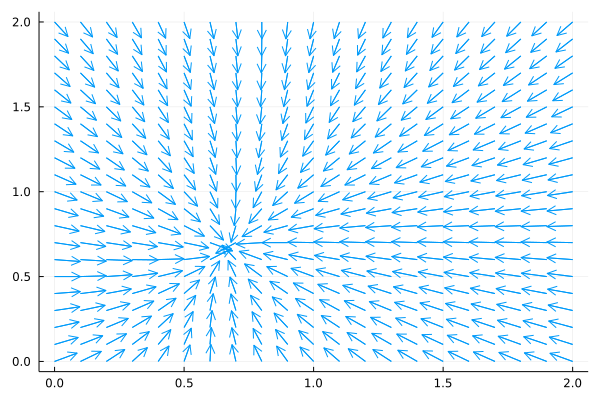

In [8]:
# First silly test
# We analyze the ODE defined by Q in R^3. 
# Since there is conservation of mass, it suffices to look at the first two coordinates

N = 3
k1 = rand(N,N,N,N)
k0 = symmetrize(k1)
f = rand(N)
function fun(x,y)
    r = Q([x,y,2-x-y],k0)
    nr = sqrt(r[1]^2+r[2]^2)
    return r[1:2]/nr/10
end
# RK4(f,fun,0.1)

xs = 0:0.1:2
ys = 0:0.1:2
using Plots
using LinearAlgebra
xxs = [x for x in xs for y in ys]
yys = [y for x in xs for y in ys]
quiver(xxs, yys, quiver=fun)



[0.0, 0.0, 0.0, 0.0]

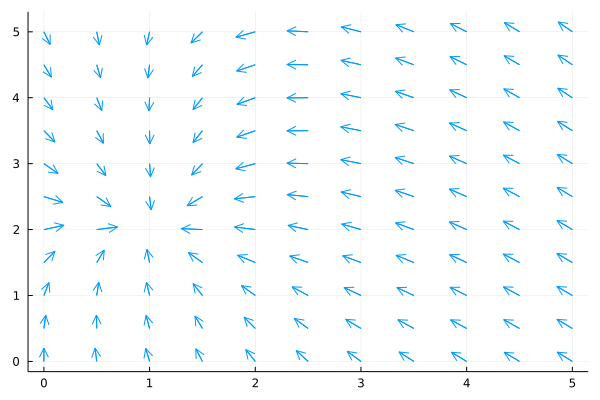

In [9]:
# Second silly test
# We analyze the ODE defined by Q in R^4. 
# Since there is conservation of mass and momentum, it suffices to look at the first two coordinates

N = 4
k1 = rand(N,N,N,N)
conserve_momentum!(k1)
k0 = symmetrize(k1)

print(Q([1.,2.,4.,8.],k0))

function fun(x,y)
    sum = 15.
    q = 34.
    w = (q - 2*sum + y + 2*x)
    z = sum - x - y - w
    r = Q([x,y,z,w],k0)
    nr = sqrt(r[1]^2+r[2]^2)
    return r[1:2]/nr/5
end
# RK4(f,fun,0.1)

xs = 0:0.5:5.
ys = 0:0.5:5.
using Plots
using LinearAlgebra
xxs = [x for x in xs for y in ys]
yys = [y for x in xs for y in ys]
quiver(xxs, yys, quiver=fun)

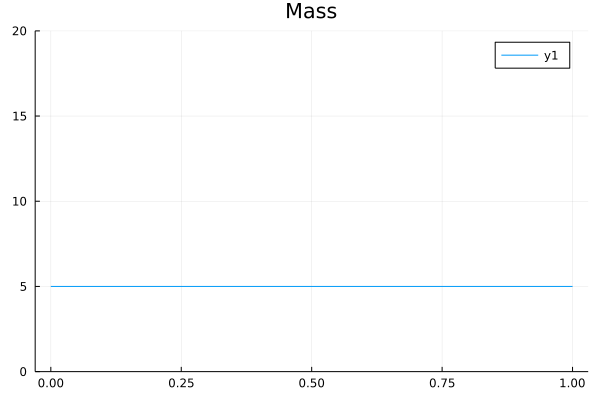

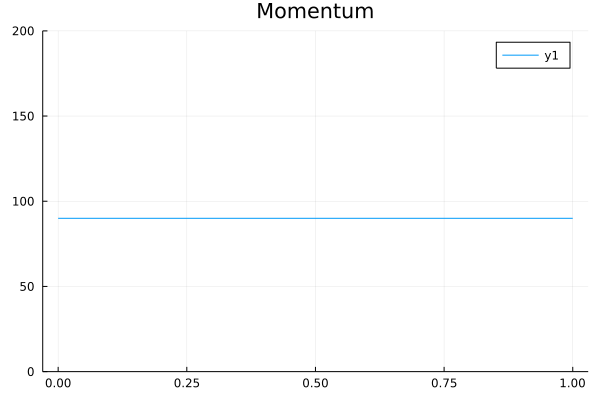

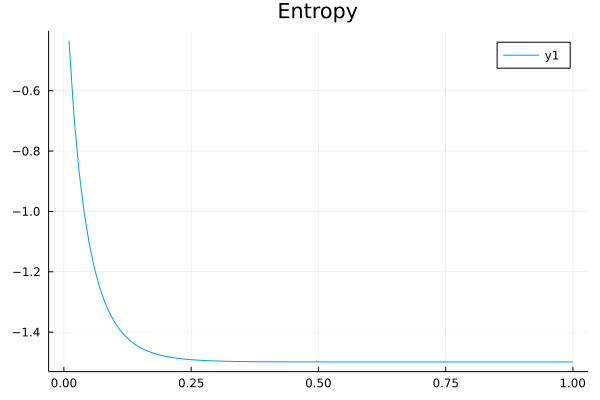

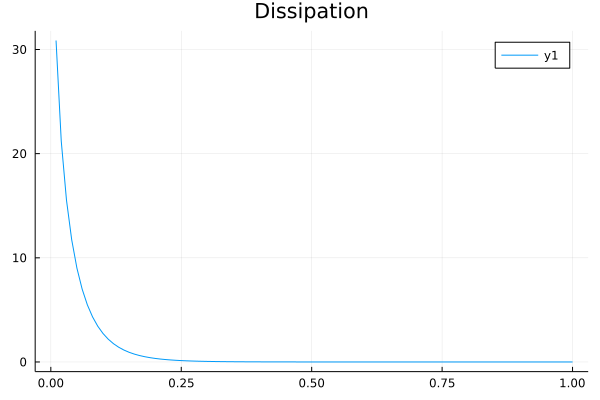

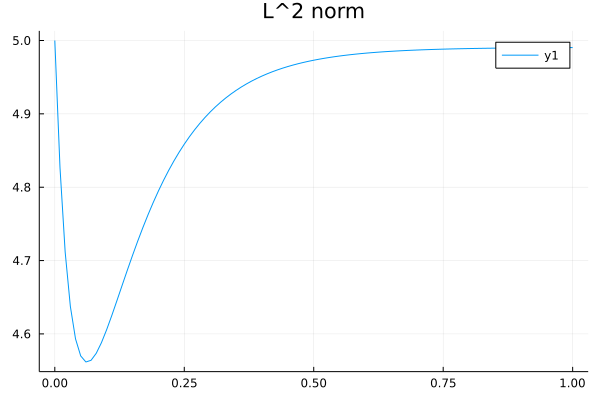

In [10]:
# Plotting conserved, monotone, and non-monotone quantities.
# Is the entropy dissipation monotone?

N = 20
k1 = rand(N,N,N,N)
conserve_momentum!(k1)
k0 = symmetrize(k1)

function Fun(x0::Vector{<:Real})
    return Q(x0,k0)
end

f0 = ones(N)
for i in 1:Int(3*N/4)
    f0[i] = 0
end


m_list = [mass(f0)]
q_list = [momentum(f0)]

h_list = [entropy(f0)]
d_list = [entropy_dissipation(f0,k0)]
l2_list = [L2norm(f0)]
t_list = [0.]

iterations = 100
h = 1. / iterations
t = 0.
for i in 1:iterations
    t += h
    push!(t_list ,t)
    f0 = RK4(f0,Fun,h)
    push!(m_list,mass(f0))
    push!(q_list,momentum(f0))
    push!(h_list,entropy(f0))
    push!(d_list,entropy_dissipation(f0,k0))
    push!(l2_list,L2norm(f0))
end

display(plot(t_list,m_list,title="Mass",ylims=(0,N)))
display(plot(t_list,q_list,title="Momentum",ylims=(0,N^2/2)))

display(plot(t_list,h_list,title="Entropy"))
display(plot(t_list,d_list,title="Dissipation"))
display(plot(t_list,l2_list,title="L^2 norm"))


We use the following code to find a state $f_\ell$ where some quantity is minimal.

It can be used to test the monotonicity of a quantity like entropy-dissipation or $L^2$-norm.

It can be used to check how much any given quantity stretches through the flow of the equation, like the $L^2$ norm or $L^\infty$ norm.

1 iterations, J=0.05417087603473777  2 iterations, J=0.03359570496959439  3 iterations, J=0.03359570496959439  4 iterations, J=0.03359570496959439  5 iterations, J=0.03359570496959439  0.03359570496959439

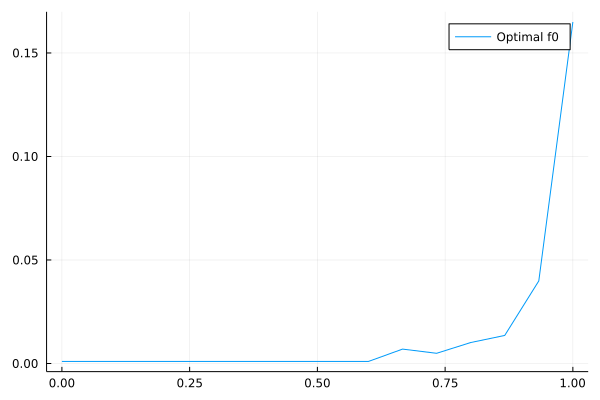

1 iterations, J=0.03271627329793286  2 iterations, J=0.03271627329793286  3 iterations, J=0.03271627329793286  4 iterations, J=0.032587963061983825  5 iterations, J=0.032587963061983825  0.032587963061983825

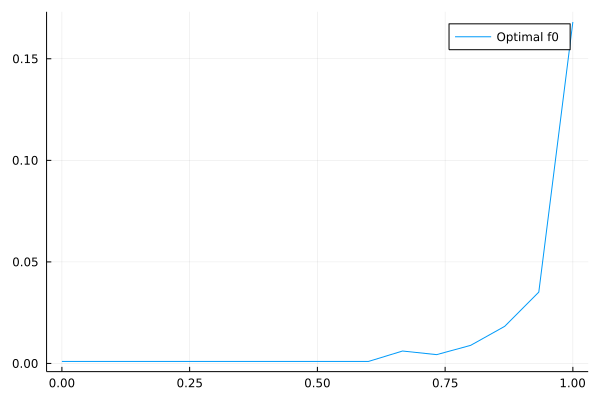

In [11]:
N = 16
k1 = rand(N,N,N,N)
conserve_momentum!(k1)
k0 = symmetrize(k1)

function Q(x0::Vector{<:Real})
    return Qm(x0,k0)
end

function J_diss(f0::Vector{<:Real})
    f1 = RK4(f0,Q,0.01)
    return entropy_dissipation(f0,k0) - entropy_dissipation(f1,k0)
end

function J_diss_diss_q(f0::Vector{<:Real})
    return entropy_dissipation_dissipation_q(f0,k0)
end

function diss_restriction(f0::Vector{<:Real})
    f1 = f0 / mass(f0) / 4
    for i in eachindex(f1)
        if (f1[i]<0.001) f1[i]=0.001 end
        if (f1[i]>1.) f1[i]=1. end
    end
    return f1
end

function max_restriction(f0::Vector{<:Real})
    f1 = f0
    for i in eachindex(f1)
        if (f1[i]<0.001) f1[i]=0.001 end
        if (f1[i]>1.) f1[i]=1. end
    end
    return f1
end 

# Setting the initial guess = 0 for the first half of the indices leads to more interesting
# data that flows into nontrivial exponentials.
f0 = rand(N)
for i in 1:Int(3*N/4)
    f0[i] = 0.001
end

h = 0.5
for i in 1:2
    h *= 0.75
    f0 = localized_stochastic_gradient_descent(f0,diss_restriction,J_diss_diss_q,5,h,report_cycle=1)
    print(J_diss_diss_q(f0))

    v0 = 0:1/(N-1):1.
    display(plot(v0,f0,label="Optimal f0"))
end


5 iterations, J=-0.8302164229790243  10 iterations, J=-1.7931967684743437  15 iterations, J=-1.7950794684662164  20 iterations, J=-1.7977981182336435  25 iterations, J=-1.7977981182336435  -1.7977981182336435

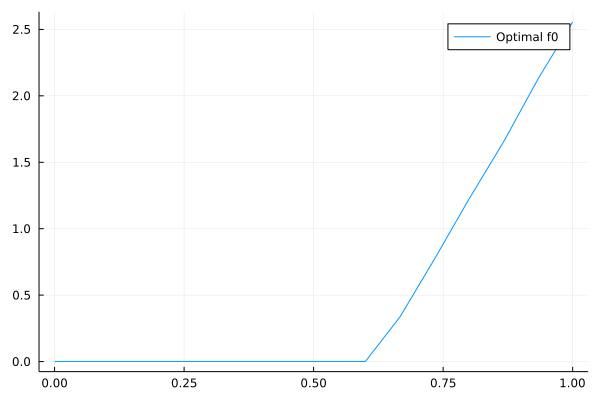

15.999999999999996 : -1.7977981182336435
5 iterations, J=-1.7977981182336435  10 iterations, J=-1.7983639273718062  15 iterations, J=-1.7983639273718062  20 iterations, J=-1.798428057481825  25 iterations, J=-1.7984305224472656  -1.7984305224472656

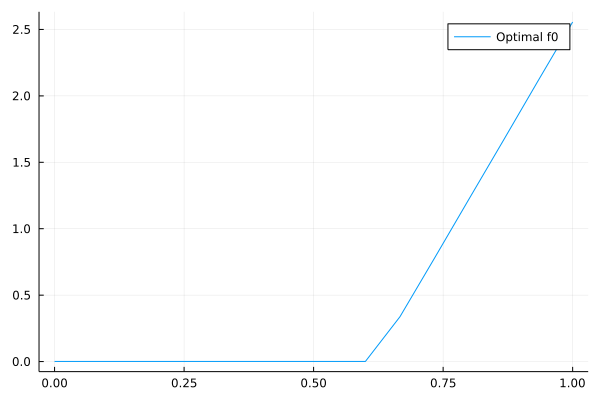

16.000000000000004 : -1.7984305224472656
5 iterations, J=-1.7984435275362358  10 iterations, J=-1.7984435275362358  15 iterations, J=-1.7984435275362358  20 iterations, J=-1.7984435275362358  25 iterations, J=-1.7984435275362358  -1.7984435275362358

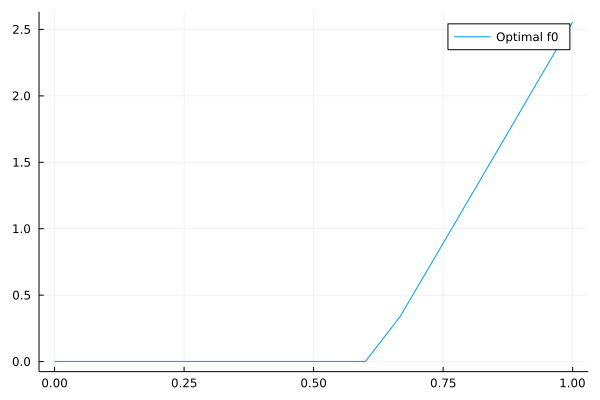

16.0 : -1.7984435275362358
5 iterations, J=-1.7984435275362358  10 iterations, J=-1.7984493641185644  15 iterations, J=-1.798520484674988  20 iterations, J=-1.798625140831291  25 iterations, J=-1.798625140831291  -1.798625140831291

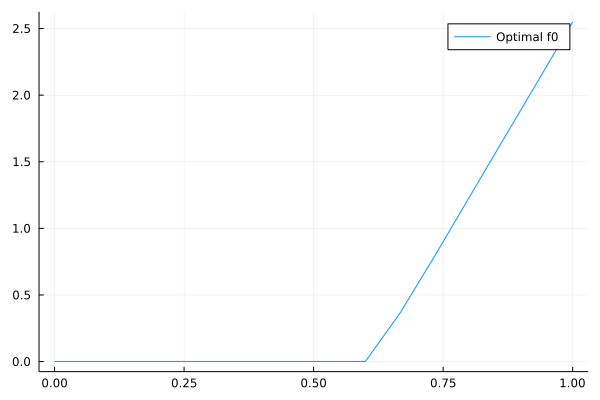

16.0 : -1.798625140831291


In [12]:
function J_L2(f0::Vector{<:Real})
    # This is a slow function. It solves the ODE up to time 1.
    h = 0.01
    f1 = f0
    for t in 0.:h:1.
        f1 = RK4(f1,Q,h)
    end
    return L2norm(f0) - L2norm(f1)
end

function J_max(f0::Vector{<:Real})
    # This is a slow function. It solves the ODE up to time 1.
    h = 0.01
    f1 = f0
    for t in 0.:h:1.
        f1 = RK4(f1,Q,h)
    end
    return maximum(f0) - maximum(f1)
end

function L2_restriction(f0::Vector{<:Real})
    f1 = f0
    for i in eachindex(f1)
        if (f1[i]<0.001) f1[i]=0.001 end
    end
    n = sqrt(L2norm(f1))
    factor = length(f0)/4/n
    return factor*f1
end 

# Setting the initial guess = 0 for the first half of the indices leads to more interesting
# data that flows into nontrivial exponentials.
f0 = rand(N)
for i in 1:Int(3*N/4)
    f0[i] = 0
end
f0 = L2_restriction(f0)

h = 0.5
for i in 1:4
    h *= 0.75
    f0 = localized_stochastic_gradient_descent(f0,L2_restriction,J_L2,25,h,report_cycle=5)
    print(J_L2(f0))

    v0 = 0:1/(N-1):1.
    display(plot(v0,f0,label="Optimal f0"))
    println(L2norm(f0)," : ",J_L2(f0))
end


1 iterations, J=1.1372924668720643  2 iterations, J=0.15541773710191187  3 iterations, J=0.0008919792200823193  4 iterations, J=0.0008919792200823193   J = 0.0008919792200823193


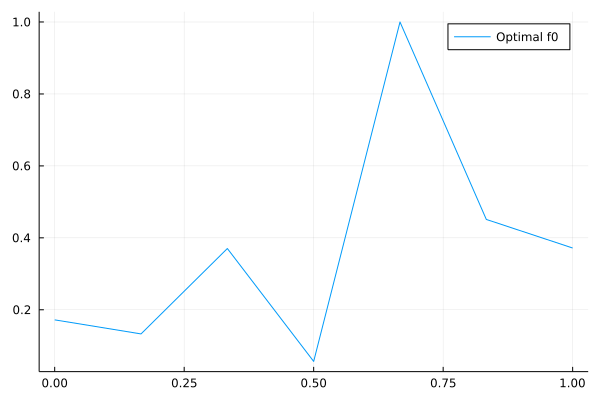

1 iterations, J=0.0008919792200823193  2 iterations, J=0.00040615849480354937  3 iterations, J=0.00040615849480354937  4 iterations, J=0.00010663953112685314   J = 0.00010663953112685314


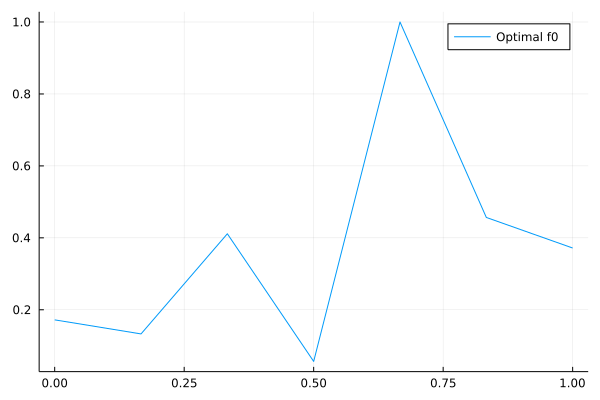

In [13]:
# This is inteded as a very sparse example

N = 7
k1 = zeros(N,N,N,N)
k1[1,2,3,4] = 4.
k1[1,5,6,7] = 4.
# conserve_momentum!(k1)
k0 = symmetrize(k1)

function J_diss_diss(f0::Vector{<:Real})
    return entropy_dissipation_dissipation(f0,k0)
end

function max_restriction(f0::Vector{<:Real})
    f1 = f0
    for i in eachindex(f1)
        if (f1[i]<0.001) f1[i]=0.001 end
        if (f1[i]>1.) f1[i]=1. end
    end
    return f1
end 

f0 = rand(N)

h = 0.5
for i in 1:2
    h *= 0.75
    f0 = localized_stochastic_gradient_descent(f0,max_restriction,J_diss_diss,4,h,report_cycle=1)
    println(" J = ",J_diss_diss(f0))

    v0 = 0:1/(N-1):1.
    display(plot(v0,f0,label="Optimal f0"))
end